In [65]:
import jax.numpy as jnp
from jax import jit, grad, vmap
import matplotlib.pyplot as plt
import numpy as np
from jax import random
from jax import jit, jacfwd, lax, jacrev, hessian

key = random.PRNGKey(0)
print(f"{key = }")

key = Array([0, 0], dtype=uint32)


In [66]:
def reference_function1(t):
    """Trajectory to track"""
    return np.array([0., 0., -3., 0.]).reshape((4,1))

def reference_function2(t):
    """Trajectory to track"""
    return np.array([np.sin(t), np.cos(t), -3., 0.]).reshape((4,1))

def reference_function3(x10, t):
    """Trajectory to track"""
    return np.array([0., 0., -(2 + np.sin(t), 0.)]).reshape((4,1))

def reference_function4(t):
    """Trajectory to track"""
    return np.array([np.sin(t), np.cos(t), -(2 + np.sin(t)), t / 10]).reshape((4,1))

def reference_function5(t):
    """Trajectory to track"""
    PERIOD = 5
    w = 2*np.pi / PERIOD
    return np.array([.35*np.sin(2*w*t), .35*np.sin(w*t), -(2 + np.sin(w*t)), 0]).reshape((4,1))


def reference_function6(t):
    """Trajectory to track"""

    return np.array([3., 0., 1., 0.,]).reshape((4,1))

In [67]:
reffunc = reference_function4

In [68]:
# Simulation parameters
T = 4.0  # Time Horizon of simulation
SIM_STEP = 0.01  # Time step of simulation
T_lookahead = 0.8  # Time horizon for Control
INTEGRATION_STEP = 0.1

NOISE_SCALING = 0.000
C = jnp.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 1]])
MASS = 1.75
GRAVITY = 9.81
ref0 = reffunc(0.0+T_lookahead)

x10 = 0.0  # initial state x
x20 = 0.0  # initial state y
x30 = -0.2  # initial state z
x40 = 0.0  # initial state vx
x50 = 0.0  # initial state vy
x60 = 0.0  # initial state vz
x70 = 0.0  # initial state phi
x80 = 0.0  # initial state theta
x90 = 0.0  # initial state psi
state0 = jnp.array([x10, x20, x30, x40, x50, x60, x70, x80, x90]).reshape((9,1))

u0_thrust = MASS * GRAVITY
u0_roll = 0.0
u0_pitch = 0.0
u0_yaw = 0.0
input0 = jnp.array([u0_thrust, u0_roll, u0_pitch, u0_yaw]).reshape((4,1))

error0 = ref0 - C@state0

i = 0

In [69]:
# Logs
states = np.zeros((int(T/SIM_STEP), len(state0)))
inputs = np.zeros((int(T/SIM_STEP), len(input0)))
refs = np.zeros((int(T/SIM_STEP), len(ref0)))
errors = np.zeros((int(T/SIM_STEP), len(ref0)))
cbfs = np.zeros((int(T/SIM_STEP), len(ref0)))
ts = np.zeros((int(T/SIM_STEP), 1))

# log initial values
states[i] = state0.flatten().tolist()
inputs[i] = input0.flatten().tolist()
refs[i] = ref0.flatten().tolist()
errors[i] = error0.flatten().tolist()
cbfs[i] = jnp.zeros_like(ref0).flatten().tolist()
ts[i] = 0.0


In [70]:
from jax import debug

@jit
def dynamics(state, input, mass):
    """Quadrotor dynamics. xdot = f(x, u)."""
    x, y, z, vx, vy, vz, roll, pitch, yaw = state
    curr_thrust, curr_rolldot, curr_pitchdot, curr_yawdot = input

    sr = jnp.sin(roll)
    sy = jnp.sin(yaw)
    sp = jnp.sin(pitch)
    cr = jnp.cos(roll)
    cp = jnp.cos(pitch)
    cy = jnp.cos(yaw)

    vxdot = -(curr_thrust / mass) * (sr * sy + cr * cy * sp)
    vydot = -(curr_thrust / mass) * (cr * sy * sp - cy * sr)
    vzdot = GRAVITY - (curr_thrust / mass) * (cr * cp)

    xdot = jnp.array([vx, vy, vz, vxdot, vydot, vzdot, curr_rolldot, curr_pitchdot, curr_yawdot]).reshape((9,1))
    return xdot


@jit
def get_next_state(state, u, timestep, key):
    """Update state using the dynamics."""
    key, subkey = random.split(key)
    # print(f"{state =}")
    # print(f"{u = }")
    dxdt = dynamics(state, u, mass=MASS)
    noise = NOISE_SCALING * random.uniform(key, (len(state0),1), minval=-0.2, maxval = 0.2)
    x_next = state + dxdt * timestep + noise
    return x_next, key


In [71]:
next_state, key = get_next_state(state0, input0, SIM_STEP, key)
print(f"{next_state = }")
print(f"{key = }")

next_state = Array([[ 0. ],
       [ 0. ],
       [-0.2],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ]], dtype=float32)
key = Array([4146024105,  967050713], dtype=uint32)


In [72]:
@jit
def fwd_euler(state, input, lookahead_step, integrations_int, mass):
    """Forward Euler integration."""
    def for_function(i, current_state):
        return current_state + dynamics(current_state, input, mass) * lookahead_step

    pred_state = lax.fori_loop(0, integrations_int, for_function, state)
    return pred_state

@jit
def predict_state(state, u, T_lookahead, lookahead_step, mass):
    """Predict the next state at time t+T via fwd euler integration of nonlinear dynamics."""
    integrations_int = (T_lookahead / lookahead_step).astype(int)
    pred_state = fwd_euler(state, u, lookahead_step, integrations_int, mass)
    return pred_state

@jit
def predict_output(state, u, T_lookahead, lookahead_step, mass):
    """Take output from the predicted states."""
    pred_state = predict_state(state, u, T_lookahead, lookahead_step, mass)
    return C @ pred_state


In [73]:
state0 + dynamics(state0, input0, MASS) * 0.1

Array([[ 0.000000e+00],
       [ 0.000000e+00],
       [-2.000000e-01],
       [ 0.000000e+00],
       [ 0.000000e+00],
       [ 9.536743e-08],
       [ 0.000000e+00],
       [ 0.000000e+00],
       [ 0.000000e+00]], dtype=float32)

In [74]:
aa = predict_state(state0, input0, T_lookahead, 0.1, MASS)
bb = fwd_euler(state0, input0, 0.1, 8, MASS)
cc = predict_output(state0, input0, T_lookahead, 0.1, MASS)
print(f"{aa = }")
print(f"{bb = }")
print(f"{cc = }")

aa = Array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [-1.9999973e-01],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 7.6293952e-07],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00]], dtype=float32)
bb = Array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [-1.9999973e-01],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 7.6293952e-07],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00]], dtype=float32)
cc = Array([[ 0.        ],
       [ 0.        ],
       [-0.19999973],
       [ 0.        ]], dtype=float32)


In [75]:
@jit
def quaternion_from_yaw(yaw):
    """Converts a yaw angle to a quaternion."""
    half_yaw = yaw / 2.0
    return jnp.array([jnp.cos(half_yaw), 0, 0, jnp.sin(half_yaw)])

@jit
def quaternion_conjugate(q):
    """Returns the conjugate of a quaternion."""
    return jnp.array([q[0], -q[1], -q[2], -q[3]])

@jit
def quaternion_multiply(q1, q2):
    """Multiplies two quaternions."""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return jnp.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

@jit
def yaw_error_from_quaternion(q):
    """Returns the yaw error from the quaternion of angular error."""
    return 2 * jnp.arctan2(q[3], q[0])

@jit
def quaternion_normalize(q):
    """Normalizes a quaternion."""
    return q / jnp.linalg.norm(q)

@jit
def shortest_path_yaw_quaternion(current_yaw, desired_yaw):
    """Returns the shortest path between two yaw angles with quaternions."""
    q_current = quaternion_normalize(quaternion_from_yaw(current_yaw))
    q_desired = quaternion_normalize(quaternion_from_yaw(desired_yaw))
    q_error = quaternion_multiply(q_desired, quaternion_conjugate(q_current))
    q_error_normalized = quaternion_normalize(q_error)
    return yaw_error_from_quaternion(q_error_normalized)

@jit
def get_tracking_error(ref, pred):
    """Calculates the tracking error between the reference and predicted outputs with yaw error handled by quaternions."""
    err = ref - pred
    yaw_err = shortest_path_yaw_quaternion(pred[3, 0], ref[3, 0])
    err = err.at[3, 0].set(yaw_err)
    return err

In [76]:
@jit
def get_jac_pred_u(state, last_input, T_lookahead, lookahead_step, mass):
    """Get the jacobian of the predicted output with respect to the control input."""
    raw_val = jacfwd(predict_output, 1)(state, last_input, T_lookahead, lookahead_step, mass)
    return raw_val.reshape((4,4))

@jit
def get_inv_jac_pred_u(state, last_input, T_lookahead, lookahead_step, mass):
    """Get the inverse of the jacobian of the predicted output with respect to the control input."""
    return jnp.linalg.pinv(get_jac_pred_u(state, last_input, T_lookahead, lookahead_step, mass).reshape((4,4)))


@jit
def execute_cbf(current, phi, max_value, min_value, gamma):
    """Execute the control barrier function."""
    zeta_max = gamma * (max_value - current) - phi
    zeta_min = gamma * (min_value - current) - phi
    v = jnp.where(current >= 0, jnp.minimum(0, zeta_max), jnp.maximum(0, zeta_min))
    return v

@jit
def integral_cbf(last_input, phi):
    """Integral control barrier function set-up for all inputs."""
    # Extract values from input
    curr_thrust, curr_roll_rate, curr_pitch_rate, curr_yaw_rate = last_input[:, 0]
    phi_thrust, phi_roll_rate, phi_pitch_rate, phi_yaw_rate = phi[:, 0]

    # CBF parameters
    thrust_gamma = 1.0  # CBF parameter
    thrust_max = 27.0  # max thrust (force) value
    thrust_min = 0.5  # min thrust (force) value
    v_thrust = execute_cbf(curr_thrust, phi_thrust, thrust_max, thrust_min, thrust_gamma)

    # CBF for rates
    rates_max_abs = 0.8  # max absolute value of roll, pitch, and yaw rates
    rates_max = rates_max_abs
    rates_min = -rates_max_abs
    gamma_rates = 1.0  # CBF parameter
    
    v_roll = execute_cbf(curr_roll_rate, phi_roll_rate, rates_max, rates_min, gamma_rates)
    v_pitch = execute_cbf(curr_pitch_rate, phi_pitch_rate, rates_max, rates_min, gamma_rates)
    v_yaw = execute_cbf(curr_yaw_rate, phi_yaw_rate, rates_max, rates_min, gamma_rates)

    v = jnp.array([[v_thrust], [v_roll], [v_pitch], [v_yaw]])
    return v

In [77]:

@jit
def NR_tracker_original(currstate, currinput, ref, T_lookahead, lookahead_step, integration_step, mass):
    """Standard Newton-Raphson method to track the reference trajectory with forward euler integration of dynamics for prediction."""
    alpha = jnp.array([20, 30, 30, 30]).reshape((4,1))
    pred = predict_output(currstate, currinput, T_lookahead, lookahead_step, mass)
    error = get_tracking_error(ref, pred) # calculates tracking error
    dgdu = get_jac_pred_u(currstate, currinput, T_lookahead, lookahead_step, mass)
    dgdu_inv = jnp.linalg.inv(dgdu)

    NR = dgdu_inv @ error # calculates newton-raphson control input without speed-up parameter
    v = integral_cbf(currinput, NR)
    udot = NR + v # udot = { inv(dg/du) * (yref - ypred) } + v = NR + v = newton-raphson control input + CBF adjustment
    change_u = udot * integration_step #crude integration of udot to get u (maybe just use 0.02 as period)
    u = currinput + alpha * change_u # u_new = u_old + alpha * change_u
    
    return u, v, error


In [78]:
dgdu = get_jac_pred_u(state0, input0, 1.2, 0.1, MASS).reshape((4,4))
print(f"{dgdu = }")

dgdu_inv = get_inv_jac_pred_u(state0, input0, 1.2, 0.1, MASS).reshape((4,4))
print(f"{dgdu_inv = }")


dgdu = Array([[ 0.        ,  0.        , -2.1582    ,  0.        ],
       [ 0.        ,  2.1582    ,  0.        ,  0.        ],
       [-0.37714288,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.2000002 ]],      dtype=float32)
dgdu_inv = Array([[ 0.        ,  0.        , -2.651515  ,  0.        ],
       [ 0.        ,  0.46334907,  0.        ,  0.        ],
       [-0.46334907,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.8333332 ]],      dtype=float32)


In [79]:
# @jit
# def error_func(state, u, T_lookahead, integration_step, C, ref):
#     """Compute the error."""
#     pred = predict_output(state, u, T_lookahead, integration_step, C)
#     return jnp.sum((ref - pred)**2)

# @jit
# #get error func derivative wrt input
# def get_grad_error_u(state, u, T_lookahead, integration_step, C, ref):
#     return jacfwd(error_func, 1)(state, u, T_lookahead, integration_step, C, ref)

# @jit
# #get hessian of error func wrt input
# def get_hess_error_u(state, u, T_lookahead, integration_step, C, ref):
#     return jacfwd(get_grad_error_u, 1)(state, u, T_lookahead, integration_step, C, ref).reshape(4,4)


In [80]:
# dgdu = get_grad_error_u(state0, input0, T_lookahead, 0.1, C, 3.0)
# print(f"{dgdu = }")
# hess = get_hess_error_u(state0, input0, T_lookahead, 0.1, C, 3.0)
# print(f"{hess = }")

In [81]:
# @jit
# def NR_tracker_2(currstate, currinput, ref, T_lookahead, integration_step, C, sim_step):
#     """Newton-Raphson method to track the reference trajectory."""
#     alpha = jnp.array([20, 30, 30, 30]).reshape((4,1))

#     pred = predict_output(currstate, currinput, T_lookahead, integration_step, C)
#     error = error_func(currstate, currinput, T_lookahead, integration_step, C, ref)
#     print(f"{pred = }")
#     print(f"{ref = }")
#     print(f"{error = }")

#     dgdu = get_grad_error_u(currstate, currinput, T_lookahead, integration_step, C, ref)
#     hess = get_hess_error_u(currstate, currinput, T_lookahead, integration_step, C, ref)
#     d2gdu2_inv = jnp.linalg.inv(hess)
#     print(f"{dgdu = }")
#     print(f"{hess = }")
#     print(f"{d2gdu2_inv = }")

#     scaling = d2gdu2_inv @ dgdu
#     print(f"{scaling = }")
#     NR = scaling
#     udot = -alpha * NR
#     print(f"{udot = }")

#     change_u = udot * sim_step
#     print(f"{change_u = }")

#     print(f"{currinput = }")
#     new_u = currinput + change_u
#     print(f"{new_u = }")
#     return new_u

In [82]:
new_u, v, error = NR_tracker_original(state0, input0, ref0, T_lookahead, 0.1, SIM_STEP, MASS)
print(f"{(new_u, v, error) = }")


(new_u, v, error) = (Array([[19.133999  ],
       [ 0.24000001],
       [-0.39174098],
       [ 0.02999999]], dtype=float32), Array([[-5.900976 ],
       [-0.4682153],
       [ 0.       ],
       [ 0.       ]], dtype=float32), Array([[ 0.7173561],
       [ 0.6967067],
       [-2.5173564],
       [ 0.08     ]], dtype=float32))


In [83]:
# new_u = NR_tracker_2(state0, input0, 0.08, T_lookahead, 0.1, C, SIM_STEP)
# print(f"{new_u = }")

In [84]:
# Run simulation
i= 0
for t in jnp.arange(SIM_STEP, T, SIM_STEP):
    print(f"Iteration #{i} at {t} seconds")
    i+=1

    currstate = states[i-1].reshape((-1,1))
    currinput = inputs[i-1].reshape((-1,1))
    # print(f"{currstate= },\n{currinput= }")
    next_state, key = get_next_state(currstate, currinput, SIM_STEP, key)

    ref = reffunc((t+T_lookahead))
    # print(f"{ref = }")

    new_input, cbf_vec, err = NR_tracker_original(currstate, currinput, ref, T_lookahead, INTEGRATION_STEP, SIM_STEP, MASS)
    # new_input = NR_tracker_2(currstate, currinput, ref, T_lookahead, INTEGRATION_STEP, C, SIM_STEP)
    # print(f"{new_input = }")

    states[i] = next_state.flatten().tolist()
    inputs[i] = new_input.flatten().tolist()
    refs[i] = reffunc(t).flatten().tolist()
    # errors[i] = (reffunc(t) - C@currstate).flatten().tolist()
    cbfs[i] = cbf_vec.flatten().tolist()
    errors[i] = err.flatten().tolist()
    ts[i] = t
    print(f"\n")
    # if i >= 9:
    #     break    

Iteration #0 at 0.009999999776482582 seconds


Iteration #1 at 0.019999999552965164 seconds


Iteration #2 at 0.029999999329447746 seconds


Iteration #3 at 0.03999999910593033 seconds


Iteration #4 at 0.04999999701976776 seconds


Iteration #5 at 0.059999994933605194 seconds


Iteration #6 at 0.07000000029802322 seconds


Iteration #7 at 0.07999999821186066 seconds


Iteration #8 at 0.08999999612569809 seconds


Iteration #9 at 0.09999999403953552 seconds


Iteration #10 at 0.10999999195337296 seconds


Iteration #11 at 0.11999999731779099 seconds


Iteration #12 at 0.12999999523162842 seconds


Iteration #13 at 0.14000000059604645 seconds


Iteration #14 at 0.15000000596046448 seconds


Iteration #15 at 0.1599999964237213 seconds


Iteration #16 at 0.17000000178813934 seconds


Iteration #17 at 0.18000000715255737 seconds


Iteration #18 at 0.1899999976158142 seconds


Iteration #19 at 0.20000000298023224 seconds


Iteration #20 at 0.20999999344348907 seconds


Iteration #21 at 0.21

In [85]:
# ts = np.arange(0, T, SIM_STEP)
x1s = states[:,0]
x2s = states[:,1]
x3s = states[:,2]
x4s = states[:,-1]

r1s = refs[:,0]
r2s = refs[:,1]
r3s = refs[:,2]
r4s = refs[:,3]

thrusts = inputs[:, 0]
ps = inputs[:, 1]
qs = inputs[:, 2]
rs = inputs[:, 3]

thrust_err = errors[:, 0]
roll_err = errors[:, 1]
pitch_err = errors[:, 2]
yaw_err = errors[:, 3]

cbf_thrust = cbfs[:, 0]
cbf_p = cbfs[:, 1]
cbf_q = cbfs[:, 2]
cbf_r = cbfs[:, 3]

In [86]:
rmse = np.sqrt(np.mean(errors**2))
print("Overall RMSE:", rmse)

Overall RMSE: 0.17495673495496125


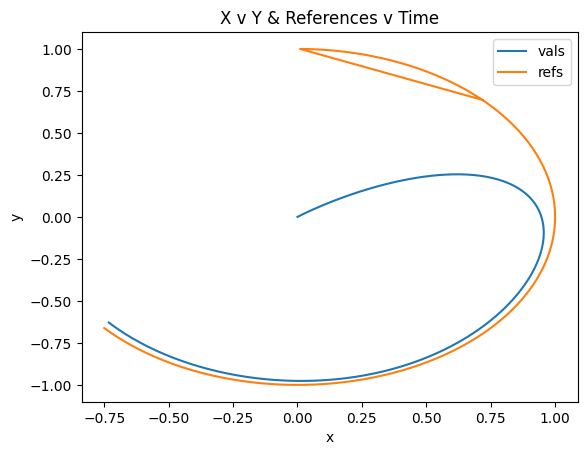

In [87]:
plt.figure(1)
plt.plot(x1s, x2s, label="vals")
plt.plot(r1s, r2s, label="refs")
plt.title("X v Y & References v Time")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

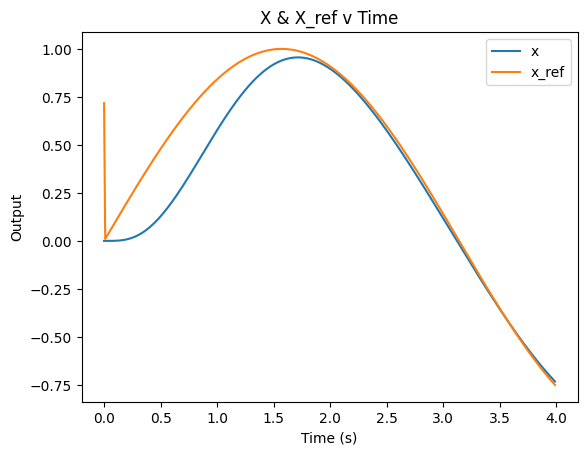

In [88]:
plt.figure(2)
plt.plot(ts, x1s, label="x")
plt.plot(ts, r1s, label="x_ref")
plt.title("X & X_ref v Time")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()

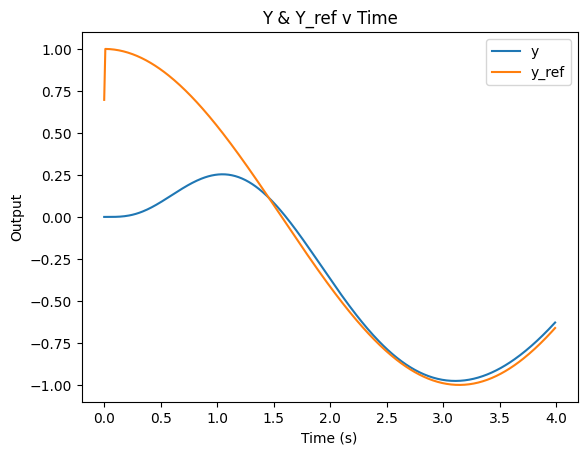

In [89]:
plt.figure(2)
plt.plot(ts, x2s, label="y")
plt.plot(ts, r2s, label="y_ref")
plt.title("Y & Y_ref v Time")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()

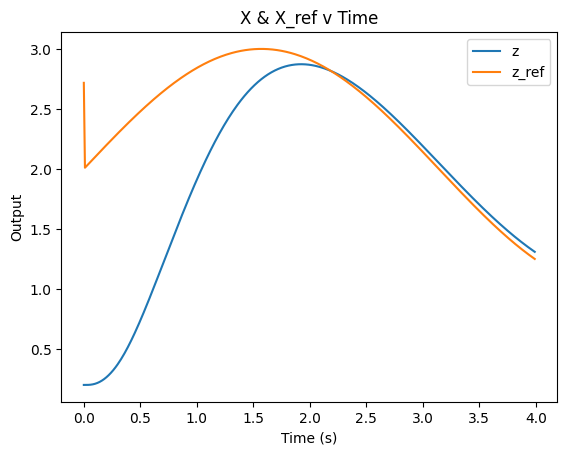

In [90]:
plt.figure(2)
plt.plot(ts, -x3s, label="z")
plt.plot(ts, -r3s, label="z_ref")
plt.title("X & X_ref v Time")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()

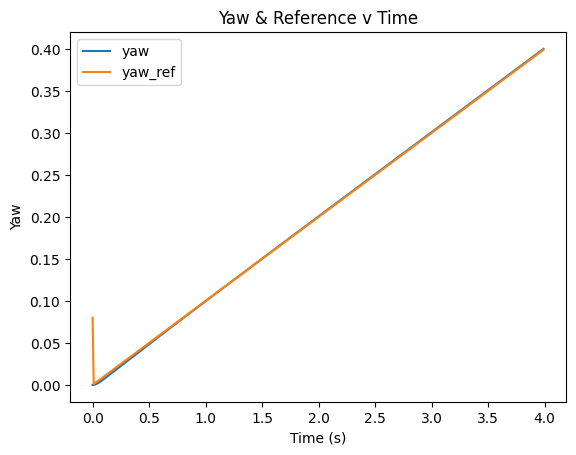

In [91]:
plt.figure(3)
plt.plot(ts, x4s, label="yaw")
plt.plot(ts, r4s, label="yaw_ref")
plt.title("Yaw & Reference v Time")
plt.xlabel("Time (s)")
plt.ylabel("Yaw")
plt.legend()

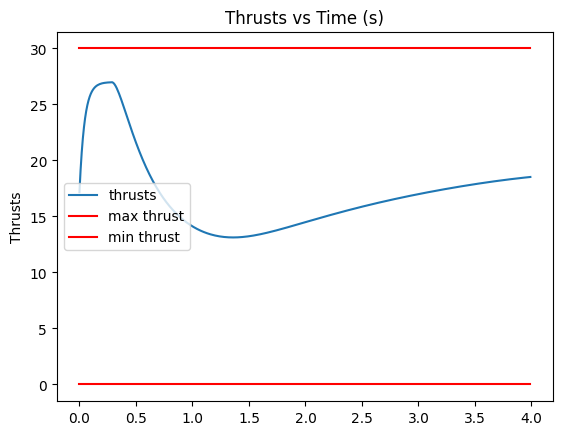

In [92]:
plt.figure(4)
plt.plot(ts, thrusts, label="thrusts")
plt.plot(ts, np.ones_like(ts)*30, label="max thrust", color="red")
plt.plot(ts, np.zeros_like(ts), label="min thrust", color="red")
plt.title("Thrusts vs Time (s)")
plt.ylabel("Thrusts")
plt.legend()

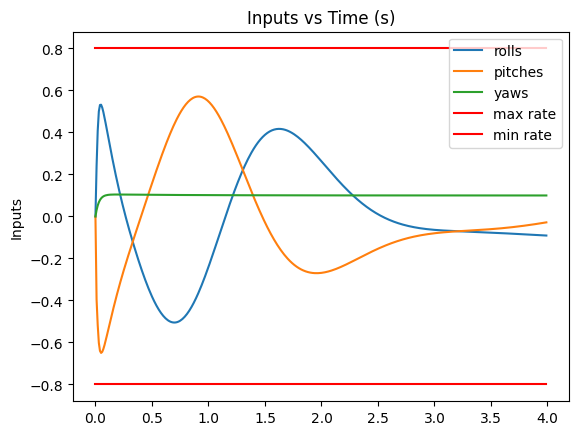

In [93]:
plt.figure(5)
plt.plot(ts, ps, label="rolls")
plt.plot(ts, qs, label="pitches")
plt.plot(ts, rs, label="yaws")
plt.plot(ts, np.ones_like(ts)*0.8, label="max rate", color="red")
plt.plot(ts, np.ones_like(ts)*-0.8, label="min rate", color="red")
plt.title("Inputs vs Time (s)")
plt.ylabel("Inputs")
plt.legend()

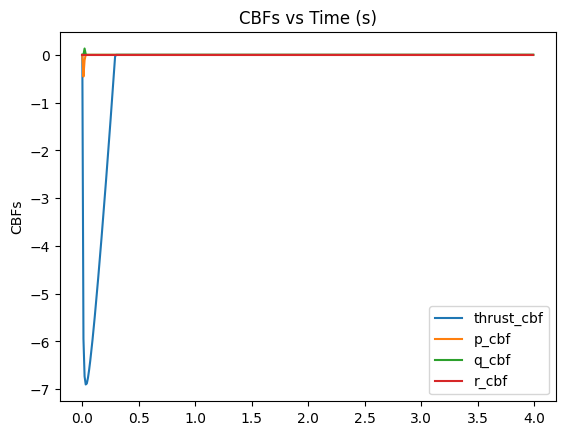

In [94]:
plt.figure(5)
plt.plot(ts, cbf_thrust, label="thrust_cbf")
plt.plot(ts, cbf_p, label="p_cbf")
plt.plot(ts, cbf_q, label="q_cbf")
plt.plot(ts, cbf_r, label="r_cbf")
plt.title("CBFs vs Time (s)")
plt.ylabel("CBFs")
plt.legend()

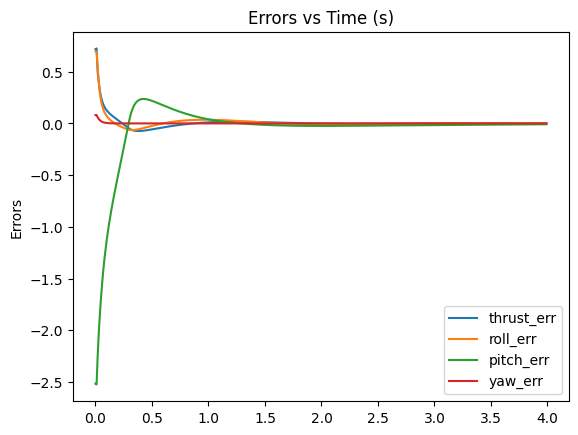

In [95]:
plt.figure(9)
plt.plot(ts, thrust_err, label="thrust_err")
plt.plot(ts, roll_err, label="roll_err")
plt.plot(ts, pitch_err, label="pitch_err")
plt.plot(ts, yaw_err, label="yaw_err")
plt.title("Errors vs Time (s)")
plt.ylabel("Errors")
plt.legend()